In [1]:
import os
import gc
#import cv2
import math
import copy
import time
import random
import glob

# Plotting
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import load_dataset
from torcheval.metrics.functional import binary_auroc
from torch.optim import lr_scheduler


from sklearn.model_selection import KFold, GroupKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/mccruz/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-07-26 13:51:03.612479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 13:51:11.519993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ls ISIC2024_Skin_Cancer_Detection


AUROC0.4759_Loss0.4727_epoch1.pth  ISIC.ipynb                test-image.hdf5
AUROC0.4996_Loss0.1373_epoch1.pth  model.safetensors         test-metadata.csv
AUROC0.5222_Loss0.3941_epoch2.pth  preprocessor_config.json  train-image/
config.json                        README.md                 train-image.hdf5
ISIC_inference.ipynb               sample_submission.csv     train-metadata.csv


In [3]:
ROOT_DIR = "/home/mccruz/isic/ISIC2024_Skin_Cancer_Detection"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

CONFIG = {
    "seed": 42,
    "n_samples_train":5000,
    "n_samples_val":5000, 
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 400,
    "valid_batch_size": 400,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 4,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [4]:
CONFIG['device'] = torch.device("cpu")

In [5]:
seed=CONFIG['seed']
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Data

In [6]:
train_df = pd.read_csv(ROOT_DIR+"/train-metadata.csv")
test_df = pd.read_csv(ROOT_DIR+"/test-metadata.csv")

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
display(train_df.head())
display(test_df.head())

/tmp/ipykernel_2260840/1934611744.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(ROOT_DIR+"/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [8]:
## Images

def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

def show_im(image_id):
    image = mpimg.imread(image_id)
    plt.imshow(image)
    plt.show()

In [9]:
for i in range(10):
    image = mpimg.imread(train_images[i])
    print(image.shape)
    

(139, 139, 3)
(127, 127, 3)
(145, 145, 3)
(109, 109, 3)
(125, 125, 3)
(119, 119, 3)
(117, 117, 3)
(157, 157, 3)
(111, 111, 3)
(127, 127, 3)


In [10]:
df = train_df.copy()
df['image_path'] = df['isic_id'].apply(get_train_file_path)
#df['image'] = df['isic_id'].apply(show_im)
df = df[ df["image_path"].isin(train_images) ].reset_index(drop=True)


print("# of images , # of positive cases, # of negative cases, # of patients")
print(df.shape, df.target.sum(), (df["target"] == 0).sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

# of images , # of positive cases, # of negative cases, # of patients
(401059, 56) 393 400666 (1042,)


## Start of Deep Learning: Pytorch

In [12]:
## CHANGE THIS, GOT THIS FROM COMMUNITY MODELS

data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "validation": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "train_testing": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        #A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        ToTensorV2()], p=1.)
}

In [13]:
class ISICDataset(Dataset):
    def __init__(self, df, phase="train", transforms=None):
        if phase == 'train':
            offset = CONFIG["n_samples_val"]
            n_samples = CONFIG["n_samples_train"]
        elif phase == 'train_testing':
            offset = CONFIG["n_samples_val"]
            n_samples = CONFIG["n_samples_train"]
        elif phase == 'validation':
            offset = 0
            n_samples = CONFIG["n_samples_val"]

        self.df_positive = df[df["target"] == 1].reset_index(drop=True)
        self.df_negative = df[df["target"] == 0].reset_index(drop=True)
        
        # Shuffle and slice the DataFrame
        self.df_negative = self.df_negative.sample(frac=1, random_state=42).reset_index(drop=True)
        self.df_negative = self.df_negative[offset:offset + n_samples // 2]

        self.transforms = transforms
        self.n_samples = n_samples

        # Generate multiple transformations for each positive sample
        self.positive_samples = []
        for idx in range(len(self.df_positive)):
            img_path = self.df_positive['image_path'].iloc[idx]
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img).copy()  # Ensure the array is copied
            for _ in range(n_samples // (2 * len(self.df_positive))):
                transformed_img = self.transforms(image=img_np.copy())["image"]
                self.positive_samples.append((transformed_img, 1))

        self.negative_samples = []
        for idx in range(len(self.df_negative)):
            img_path = self.df_negative['image_path'].iloc[idx]
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img).copy()  # Ensure the array is copied
            transformed_img = self.transforms(image=img_np)["image"]
            self.negative_samples.append((transformed_img, 0))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        if random.random() < 0.5:
            idx = index % len(self.positive_samples)
            img, target = self.positive_samples[idx]
        else:
            idx = index % len(self.negative_samples)
            img, target = self.negative_samples[idx]

        return {
            'image': img,
            'target': target
        }


In [14]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
    train_df.loc[valid_index, "fold"] = int(fold)
    
display(train_df.groupby('fold').size()), 
display(train_df.head())

fold
0.0    80214
1.0    80212
2.0    80211
3.0    80211
4.0    80211
dtype: int64

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,fold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,3.0
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,1.0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,4.0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,1.0
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0.0


In [15]:
## Model
#dataset = load_dataset("huggingface/cats-image")
#image = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

#inputs = processor(image, return_tensors="pt")

#with torch.no_grad():
#    logits = model(**inputs).logits

## model predicts one of the 1000 ImageNet classes
#predicted_label = logits.argmax(-1).item()
#print(model.config.id2label[predicted_label])


In [30]:
new_classifier = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=2048, out_features=2, bias=True),
    nn.Sigmoid()
)

# Replace the old classifier with the new one
model.classifier = new_classifier

for param in model.parameters():
    param.requires_grad = False

    
for param in model.classifier.parameters():
    param.requires_grad = True

# Verify which parameters require gradients
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [31]:
def criterion(outputs, targets):
    return nn.MSELoss()(outputs, targets)

In [32]:
#train_dataset = ISICDataset(df, phase = "train", transforms=data_transforms["train"])
#valid_dataset = ISICDataset(df, phase = "validation", transforms=data_transforms["validation"])
train_dataset = ISICDataset(df, phase = "train", transforms=data_transforms["train_testing"])
valid_dataset = ISICDataset(df, phase = "validation", transforms=data_transforms["train_testing"])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                          num_workers=3, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=3, shuffle=False, pin_memory=True)

In [33]:
device = torch.device("cpu")

In [34]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    device = torch.device("cpu")  # or CONFIG["device"]
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0

    for step, batch in enumerate(train_loader):
        print(step)
        images = batch['image'].to(device, dtype=torch.float)
        targets = batch['target'].to(device, dtype=torch.int64)  # Ensure targets are int64 for class indices

        
        batch_size = images.size(0)

        model = model.to(device)

        # Ensure images are properly processed
        inputs = processor(images, return_tensors="pt").to(device)

        # No need for torch.no_grad() during training
        logits = model(**inputs).logits  # Get raw logits

        # Choose the appropriate loss function
        loss = criterion(logits, torch.nn.functional.one_hot(targets, num_classes=2) * 1.0)  # Ensure targets are not one-hot encoded
        loss = loss / CONFIG['n_accumulate']

        print(loss)

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        # Calculate AUROC after ensuring predicted labels are generated correctly
        predicted_label = torch.argmax(logits, dim=-1)  # Ensure to get class indices
        auroc = binary_auroc(input=predicted_label, target=targets).item()  # Ensure targets are class indices

        running_loss += (loss.item() * batch_size)
        running_auroc += (auroc * batch_size)
        dataset_size += batch_size

        train_epoch_loss = running_loss / dataset_size
        train_epoch_auroc = running_auroc / dataset_size

    gc.collect()

    return train_epoch_loss, train_epoch_auroc

In [35]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    for batch in valid_loader:   
        images = batch['image'].to(device, dtype=torch.float)
        targets = batch['target'].to(device, dtype=torch.int64)  # Ensure targets are int64 for class indices

        
        batch_size = images.size(0)

        model = model.to(device)

        # Ensure images are properly processed
        inputs = processor(images, return_tensors="pt").to(device)

        # No need for torch.no_grad() during training
        logits = model(**inputs).logits  # Get raw logits

        # Choose the appropriate loss function
        loss = criterion(logits, torch.nn.functional.one_hot(targets, num_classes=2) * 1.0)  # Ensure targets are not one-hot encoded
        loss = loss / CONFIG['n_accumulate']

        
        print(loss)

        predicted_label = torch.argmax(logits, dim=-1)  # Ensure to get class indices
        auroc = binary_auroc(input=predicted_label, target=targets).item()  # Ensure targets are class indices

        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
      
    gc.collect()
    
    return epoch_loss, epoch_auroc

In [36]:
if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

In [37]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [38]:
device = torch.device("cpu") 

In [39]:
    num_epochs=20
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)

In [42]:
history['Valid AUROC']

[0.49812847845252234,
 0.5030194056833504,
 0.4924045197869984,
 0.5356672708996466,
 0.5720451274620824,
 0.6106867650358456,
 0.6330997795892573,
 0.6293383375850106,
 0.6440417113660198,
 0.6632086251897714,
 0.6718333495100617,
 0.6687353690818427,
 0.6775851423265923,
 0.6685042200432703,
 0.67365654774266,
 0.6797734112115932,
 0.6855766103345577,
 0.6918963069449977,
 0.6787502744870187,
 0.6847862361877399]

In [ ]:
    

    #start = time.time()
    #best_model_wts = copy.deepcopy(model.state_dict())
    #best_epoch_auroc = -np.inf
    #history = {"Train Loss": [], "Valid Loss": [], 'Train AUROC': [], 'Valid AUROC' : [], 'lr' : []}
    
    for epoch in range(20, 40): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        print(history)
        # deep copy the model
        if 2>1:# best_epoch_auroc <= val_epoch_auroc:
            print(f"Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "/home/mccruz/isic/ISIC2024_Skin_Cancer_Detection/v2_AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.pth".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    

0
tensor(0.2331, grad_fn=<DivBackward0>)
1
tensor(0.2339, grad_fn=<DivBackward0>)
2
tensor(0.2321, grad_fn=<DivBackward0>)
3
tensor(0.2301, grad_fn=<DivBackward0>)
4
tensor(0.2308, grad_fn=<DivBackward0>)
5
tensor(0.2325, grad_fn=<DivBackward0>)
6
tensor(0.2303, grad_fn=<DivBackward0>)
7
tensor(0.2367, grad_fn=<DivBackward0>)
8
tensor(0.2311, grad_fn=<DivBackward0>)
9
tensor(0.2325, grad_fn=<DivBackward0>)
10
tensor(0.2291, grad_fn=<DivBackward0>)
11
tensor(0.2351, grad_fn=<DivBackward0>)
tensor(0.2334)
tensor(0.2333)
tensor(0.2372)
tensor(0.2319)
tensor(0.2316)
tensor(0.2313)
tensor(0.2358)
tensor(0.2346)
tensor(0.2337)
tensor(0.2327)
tensor(0.2318)
tensor(0.2306)
tensor(0.2305)
{'Train Loss': [0.4438883761564891, 0.3394356494148572, 0.2904859607418378, 0.2502378361920516, 0.2487401788433393, 0.24734292179346085, 0.24613447859883308, 0.24479190508524576, 0.24373143911361694, 0.24263737226525942, 0.24139014755686125, 0.24078464383880296, 0.23918119569619498, 0.23847502345840135, 0.2380

Model Saved

0
tensor(0.2303, grad_fn=<DivBackward0>)
1
tensor(0.2320, grad_fn=<DivBackward0>)
2
tensor(0.2328, grad_fn=<DivBackward0>)
3
tensor(0.2306, grad_fn=<DivBackward0>)
4
tensor(0.2318, grad_fn=<DivBackward0>)
5
tensor(0.2300, grad_fn=<DivBackward0>)
6
tensor(0.2304, grad_fn=<DivBackward0>)
7
tensor(0.2299, grad_fn=<DivBackward0>)
8
tensor(0.2294, grad_fn=<DivBackward0>)
9
tensor(0.2360, grad_fn=<DivBackward0>)
10
tensor(0.2305, grad_fn=<DivBackward0>)
11
tensor(0.2301, grad_fn=<DivBackward0>)
tensor(0.2318)
tensor(0.2360)
tensor(0.2349)
tensor(0.2293)
tensor(0.2307)
tensor(0.2333)
tensor(0.2349)
tensor(0.2350)
tensor(0.2337)
tensor(0.2293)
tensor(0.2337)
tensor(0.2324)
tensor(0.2296)
{'Train Loss': [0.4438883761564891, 0.3394356494148572, 0.2904859607418378, 0.2502378361920516, 0.2487401788433393, 0.24734292179346085, 0.24613447859883308, 0.24479190508524576, 0.24373143911361694, 0.24263737226525942, 0.24139014755686125, 0.24078464383880296, 0.23918119569619498, 0.238475023458

Model Saved

0
tensor(0.2336, grad_fn=<DivBackward0>)
1
tensor(0.2300, grad_fn=<DivBackward0>)
2
tensor(0.2303, grad_fn=<DivBackward0>)
3
tensor(0.2316, grad_fn=<DivBackward0>)
4
tensor(0.2296, grad_fn=<DivBackward0>)
5
tensor(0.2287, grad_fn=<DivBackward0>)
6
tensor(0.2298, grad_fn=<DivBackward0>)
7
tensor(0.2310, grad_fn=<DivBackward0>)
8
tensor(0.2288, grad_fn=<DivBackward0>)
9
tensor(0.2306, grad_fn=<DivBackward0>)
10
tensor(0.2290, grad_fn=<DivBackward0>)
11
tensor(0.2301, grad_fn=<DivBackward0>)
tensor(0.2319)
tensor(0.2316)
tensor(0.2297)
tensor(0.2301)
tensor(0.2315)
tensor(0.2294)
tensor(0.2329)
tensor(0.2277)
tensor(0.2337)
{'Train Loss': [0.4438883761564891, 0.3394356494148572, 0.2904859607418378, 0.2502378361920516, 0.2487401788433393, 0.24734292179346085, 0.24613447859883308, 0.24479190508524576, 0.24373143911361694, 0.24263737226525942, 0.24139014755686125, 0.24078464383880296, 0.23918119569619498, 0.23847502345840135, 0.2380119226872921, 0.23671063284079233, 0.2352174359

Model Saved

0
tensor(0.2302, grad_fn=<DivBackward0>)
1
tensor(0.2321, grad_fn=<DivBackward0>)
2
tensor(0.2289, grad_fn=<DivBackward0>)
3
tensor(0.2305, grad_fn=<DivBackward0>)
4
tensor(0.2244, grad_fn=<DivBackward0>)
5
tensor(0.2315, grad_fn=<DivBackward0>)
6
tensor(0.2295, grad_fn=<DivBackward0>)
7
tensor(0.2294, grad_fn=<DivBackward0>)
8
tensor(0.2241, grad_fn=<DivBackward0>)
9
tensor(0.2265, grad_fn=<DivBackward0>)
10
tensor(0.2291, grad_fn=<DivBackward0>)
11
tensor(0.2291, grad_fn=<DivBackward0>)
tensor(0.2296)
tensor(0.2356)
tensor(0.2322)
tensor(0.2276)
tensor(0.2291)
tensor(0.2273)
tensor(0.2334)
tensor(0.2321)
tensor(0.2296)
tensor(0.2265)
tensor(0.2302)
tensor(0.2313)
tensor(0.2312)
{'Train Loss': [0.4438883761564891, 0.3394356494148572, 0.2904859607418378, 0.2502378361920516, 0.2487401788433393, 0.24734292179346085, 0.24613447859883308, 0.24479190508524576, 0.24373143911361694, 0.24263737226525942, 0.24139014755686125, 0.24078464383880296, 0.23918119569619498, 0.238475023458

tensor(0.2287, grad_fn=<DivBackward0>)
5
tensor(0.2288, grad_fn=<DivBackward0>)
6
tensor(0.2296, grad_fn=<DivBackward0>)
7
tensor(0.2313, grad_fn=<DivBackward0>)
8
tensor(0.2261, grad_fn=<DivBackward0>)
9
tensor(0.2305, grad_fn=<DivBackward0>)
10
tensor(0.2290, grad_fn=<DivBackward0>)
11
tensor(0.2285, grad_fn=<DivBackward0>)
tensor(0.2294)
tensor(0.2324)
tensor(0.2305)


In [100]:
        #history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        #history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "/home/mccruz/isic/ISIC2024_Skin_Cancer_Detection/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.pth".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()

Validation AUROC Improved (0.4996 ---> 0.4996)
Model Saved



In [ ]:
1

In [21]:
for batch in train_loader:
    print(batch['image'].shape, batch['target'])

torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])

torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0])

In [134]:
batch['target']

tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [142]:
batch['image'][batch['target']==1,:,:,:].shape

torch.Size([2, 3, 384, 384])

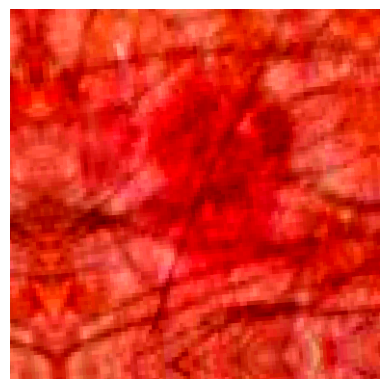

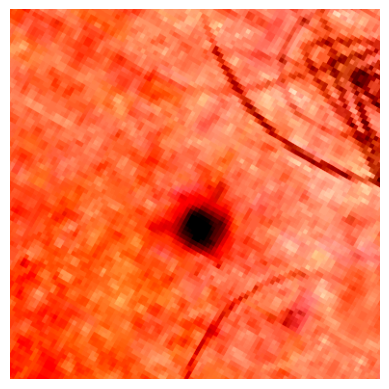

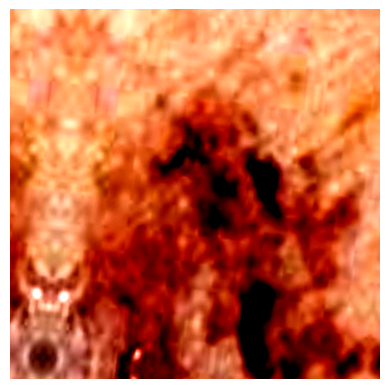

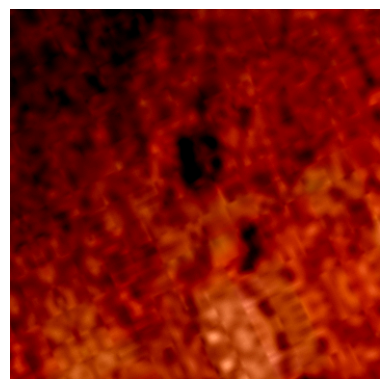

In [136]:
for i in range(4):
    image_array = batch['image'][batch['target']==1,:,:,:][i]
    if image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.show()

In [137]:
## CHANGE THIS, GOT THIS FROM COMMUNITY MODELS

data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "validation": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [138]:
train_dataset = ISICDataset(df, phase = "train", transforms=data_transforms["train"])
valid_dataset = ISICDataset(df, phase = "validation", transforms=data_transforms["validation"])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                          num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

In [139]:
for batch in train_loader:
    print(batch['image'].shape, batch['target'])

torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

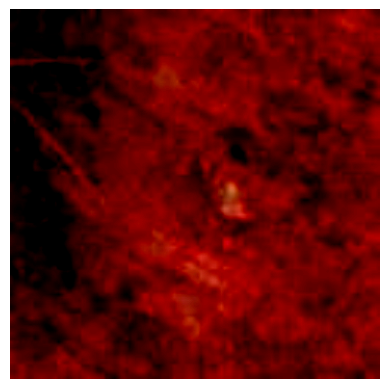

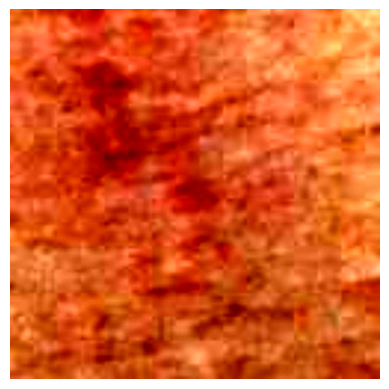

In [146]:
for i in range(2):
    image_array = batch['image'][batch['target']==1,:,:,:][i]
    if image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.show()